In [3]:
# Purpose of this cell:
# Defines the core data structures and helper functions for building a Modal Isolation Tree (MIT)
# and a simple Modal Isolation Forest (MIF). Splits can use neighbor-based “modalities” (Y, EQ, X).

import numpy as np
from dataclasses import dataclass
from typing import Optional, List, Tuple, Sequence, Dict, Any


# Helper data structures

@dataclass
class ExNode:
    """Leaf node: holds the size of the sub-sample (number of active indices at this leaf)."""
    size: int


@dataclass
class InNode:
    """Internal node: split parameters and children."""
    modality: str           # 'Y', 'EQ', or 'X'
    m: np.ndarray           # direction (unit) vector, R^n
    t: float                # scalar threshold (x · m > t)
    left: object            # ExNode or InNode
    right: object           # ExNode or InNode


# Random sampling helpers (EIF-style)

def sample_m(h: int, rng: np.random.Generator) -> np.ndarray:
    """
    m ∈ R^h: Sample a random unit direction vector.
    Steps: Draw from Normal(0,1), then normalize.
    Why: To obtain a direction uniformly on the unit sphere.
    """
    v = rng.normal(size=h)
    nrm = np.linalg.norm(v)
    if nrm == 0:
        return sample_m(h, rng)  # retry if zero vector
    m = v / nrm
    return m

def sample_b_dot_m(X: np.ndarray, m: np.ndarray, rng: np.random.Generator) -> float:
    """
    Produce the scalar threshold b·m (we don’t need b itself).
    Steps:
      1) For all w ∈ X compute projections: p = w · m = (X @ m).
      2) Sample t ~ Uniform( min(p), max(p) ).
      3) Set b·m := t (decision rule: (w · m) > b·m).
    Note: If desired, you can define a vector b along m as b = (b·m) * m;
          then (w - b) · m = (w · m) - (b · m).
    """
    proj = X @ m
    pmin, pmax = proj.min(), proj.max()
    if pmin == pmax:
        return float(pmin)  # degenerate case; safe fallback    
    return float(rng.uniform(pmin, pmax))


def decide_one(w: np.ndarray, m: np.ndarray, b_dot_m: float) -> bool:
    """
    Decision for a single sample:
      (w - b) · m > 0  ⇔  (w · m) > (b · m)
    Here we only keep b·m (the scalar).
    True: send to the left (>) branch; False: send to the right (≤) branch.
    """
    return bool(w @ m > b_dot_m)


def _choose_modality(pbar: Sequence[float], rng: np.random.Generator) -> str:
    """
    Choose modality. Order in p̄: (Y, EQ, X).
    """
    choices = np.array(["Y", "EQ", "X"])
    probs = np.array(pbar, dtype=float)
    probs = probs / probs.sum()  # normalize for safety
    return rng.choice(choices, p=probs)

# Splittability and filtering

def _cannot_split(X_idx: np.ndarray) -> bool:
    """
    Basic stopping rule: cannot split if there is one or zero elements.
    """
    return X_idx.size <= 1


def _apply_condition(
    X: np.ndarray,
    idx: int,
    modality: str,
    m: np.ndarray,
    t: float
) -> Optional[bool]:
    """
    Decision: (chosen neighbor vector) · m > t ?
    - EQ: use current sample i
    - Y : use i-1 (if missing → None)
    - X : use i+1 (if missing → None)
    If None is returned, the caller will fall back to EQ for a definitive decision.
    """
    if modality == "EQ":
        vec = X[idx]
    elif modality == "Y":
        if idx - 1 < 0:
            return None
        vec = X[idx - 1]
    elif modality == "X":
        if idx + 1 >= len(X):
            return None
        vec = X[idx + 1]
    else:
        raise ValueError(f"Unknown modality: {modality}")

    return decide_one(vec, m, t)


def _split_indices(
    X: np.ndarray,
    X_idx: np.ndarray,
    modality: str,
    m: np.ndarray,
    t: float
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Split the active indices X_idx into two sets based on the chosen modality and (m, t).
    - Practical rule for undecidable (None) cases: fall back to EQ and test again.
    """
    left_idx = []
    right_idx = []

    for i in X_idx:
        c = _apply_condition(X, int(i), modality, m, t)

        if c is None:
            # Fall back to EQ (always defined) for a definitive decision
            c = _apply_condition(X, int(i), "EQ", m, t)
            assert c is not None, "EQ should always yield a decision."

        if c:
            left_idx.append(i)
        else:
            right_idx.append(i)

    return np.array(left_idx, dtype=int), np.array(right_idx, dtype=int)


# MIF (forest builder): 

def MIF(
    X: np.ndarray,
    t: int,                          # number of trees
    T: int,                          # sub-sample size per tree
    pbar: Sequence[float],           # (pY, pEQ, pX)
    qbar: Optional[Dict[str, Any]] = None,
    rng: Optional[np.random.Generator] = None
) -> List[object]:
    """
    MIF(X, t, T, p̄, q̄): Build t MITs (controlled by q̄ if used) and return the forest.

    Notes:
      - T: number of indices to select per tree (sub-sampling).
      - N: total number of time steps / samples in X (X.shape[0]).
    """
    if rng is None:
        rng = np.random.default_rng()

    N = X.shape[0]                     # data length
    if T > N:
        raise ValueError(f"T cannot exceed N: T={T}, N={N}")
    forest: List[object] = []

    for _ in range(t):
        # Draw a sub-sample of indices without replacement
        X_prime = np.sort(rng.choice(N, size=T, replace=False))
        tree = MIT(X_prime, X, pbar)
        forest.append(tree)

    return forest


# MIT (single tree): 

def MIT(
    X_prime: np.ndarray,     # active indices at this node
    X: np.ndarray,           # data of shape (N, h)
    pbar: Sequence[float]    # (pY, pEQ, pX)
) -> object:
    """
    MIT(X', X, p̄)
    Threshold t = b·m is sampled from the projection range of the active subset.
    """
    if _cannot_split(X_prime):
        return ExNode(size=int(X_prime.size))

    rng = np.random.default_rng()
    h = X.shape[1]
    MAX_RETRIES = 16

    for _ in range(MAX_RETRIES):
        op = _choose_modality(pbar, rng)         # 'Y' / 'EQ' / 'X'
        m  = sample_m(h, rng)                    # m ∈ R^h, ||m||=1
        t  = sample_b_dot_m(X[X_prime], m, rng)  # t = b·m (scalar only)

        L, R = _split_indices(X, X_prime, op, m, t)
        if L.size > 0 and R.size > 0:
            left  = MIT(L, X, pbar)
            right = MIT(R, X, pbar)
            return InNode(modality=op, m=m, t=t, left=left, right=right)

    # If no valid split is found after retries, return a leaf
    return ExNode(size=int(X_prime.size))

In [5]:
# Purpose of this cell:
# Provides a minimal test bench and a simple anomaly scorer for a Modal Isolation Forest (MIF).
# It computes path lengths per tree, normalizes them, and converts to anomaly scores in [0, 1].

from typing import Union, Tuple, List
import numpy as np

Node = Union[ExNode, InNode]

def _c(n: int) -> float:
    """
    Isolation Forest normalization constant.
    Goal: compare path lengths fairly across different leaf sizes.
    
    Formula:
      c(n) = 2 * H_{n-1} - 2 * (n-1) / n
    where H_{k} = 1 + 1/2 + ... + 1/k (harmonic number).
    
    Notes:
      - If n <= 1, returning 0 is a common safe choice.
      - In IF literature, when a leaf has 'size = s', c(s) is added
        to the total path length (to account for stopping before full isolation).
    """
    if n <= 1:
        return 0.0
    h = sum(1.0 / k for k in range(1, n))  # H_{n-1}
    return 2.0 * h - 2.0 * (n - 1) / n

def _route_one(tree: Node, X: np.ndarray, i: int) -> Tuple[int, int]:
    """
    Route a single sample (index i) from root to leaf.
    
    Returns:
      depth      : number of internal nodes traversed
      leaf_size  : number of samples at the reached leaf (ExNode.size)
    
    Notes:
      - Even if the tree was trained on sub-samples, scoring over the full X is natural (IF approach).
      - If the chosen modality is not applicable (e.g., Y when i-1 is missing),
        fall back to EQ (current sample) for a safe decision.
    """
    depth = 0
    node = tree
    while isinstance(node, InNode):
        c = _apply_condition(X, i, node.modality, node.m, node.t)
        if c is None:
            # Edge case (first/last index): fall back to EQ
            c = _apply_condition(X, i, "EQ", node.m, node.t)
        node = node.left if c else node.right
        depth += 1

    # node is now ExNode; .size holds how many samples are at this leaf
    return depth, node.size  # type: ignore[attr-defined]

def path_length_one(tree: Node, X: np.ndarray, i: int) -> float:
    """
    Effective path length for sample i in a single tree.
    
    Logic:
      - Raw path length: number of levels until the leaf (depth).
      - If leaf size is s, add c(s) per IF tradition
        (compensates for stopping before full isolation).
    """
    depth, leaf_size = _route_one(tree, X, i)
    return depth + _c(leaf_size)

def score_forest(forest: List[Node], X: np.ndarray, T_subsample: int) -> np.ndarray:
    """
    Compute anomaly scores for every sample in the forest.
    
    Formula:
      s(i) = 2 ^ ( - E[h(i)] / c(T) )
    - E[h(i)] : average path length across trees
    - c(T)    : normalization constant for the training sub-sample size T
    
    Expectations:
      - Scores lie in [0, 1].
      - Values closer to 1 indicate more anomalous samples.
    
    Notes:
      - T_subsample should match the T used during training.
      - If T_subsample <= 1, use 1.0 to avoid division by zero (safety).
    """
    N = X.shape[0]
    cT = _c(T_subsample) if T_subsample > 1 else 1.0  # guard against division by zero
    H = np.zeros(N, dtype=float)

    # Average path length per sample
    for i in range(N):
        h_sum = 0.0
        for tree in forest:
            h_sum += path_length_one(tree, X, i)
        H[i] = h_sum / len(forest)

    # IF score transform
    scores = np.power(2.0, -H / cT)
    return scores

if __name__ == "__main__":
    # --------------------------
    # 1) Synthetic data + anomalies
    # --------------------------
    rng = np.random.default_rng(42)
    N, h = 220, 3
    X = rng.normal(loc=0.0, scale=1.0, size=(N, h))

    # Add a few obvious point anomalies (large deviation)
    anomaly_idx = [50, 120, 180, 200]
    for idx in anomaly_idx:
        X[idx] += rng.normal(loc=8.0, scale=0.5, size=h)

    # --------------------------
    # 2) Build the forest
    # --------------------------
    pbar = [0.2, 0.6, 0.2]    # modality probabilities (Y, EQ, X)
    t_trees = 50              # number of trees
    T_sub = 64                # sub-sample size (T)
    forest = MIF(X, t=t_trees, T=T_sub, pbar=pbar, rng=rng)

    # --------------------------
    # 3) Score
    # --------------------------
    scores = score_forest(forest, X, T_subsample=T_sub)

    # --------------------------
    # 4) Top-10 most anomalous samples
    # --------------------------
    top_k = 10
    top_idx = np.argsort(scores)[::-1][:top_k]  # descending by score
    print("Top", top_k, "most anomalous samples:")
    for rank, i in enumerate(top_idx, start=1):
        tag = "(injected anomaly)" if i in anomaly_idx else ""
        print(f"{rank:2d}. i={i:3d}  score={scores[i]:.4f}  {tag}")

Top 10 most anomalous samples:
 1. i=120  score=0.7259  (injected anomaly)
 2. i=180  score=0.6957  (injected anomaly)
 3. i=200  score=0.6944  (injected anomaly)
 4. i= 50  score=0.6791  (injected anomaly)
 5. i= 82  score=0.5760  
 6. i=179  score=0.5664  
 7. i= 46  score=0.5664  
 8. i=168  score=0.5530  
 9. i= 81  score=0.5469  
10. i=125  score=0.5459  


NPZ loaded: key=X, shape=(233, 200)

Top 20 most anomalous samples:
 1. i= 206  score=0.7057
 2. i= 217  score=0.7028
 3. i= 207  score=0.7008
 4. i= 219  score=0.6497
 5. i= 218  score=0.6106
 6. i= 220  score=0.5916
 7. i= 221  score=0.5707
 8. i= 200  score=0.5204
 9. i=  70  score=0.5070
10. i= 222  score=0.4993
11. i=  83  score=0.4811
12. i=  41  score=0.4791
13. i= 205  score=0.4791
14. i= 199  score=0.4680
15. i=  42  score=0.4648
16. i=  86  score=0.4629
17. i= 117  score=0.4623
18. i=  25  score=0.4610
19. i= 226  score=0.4604
20. i= 195  score=0.4591


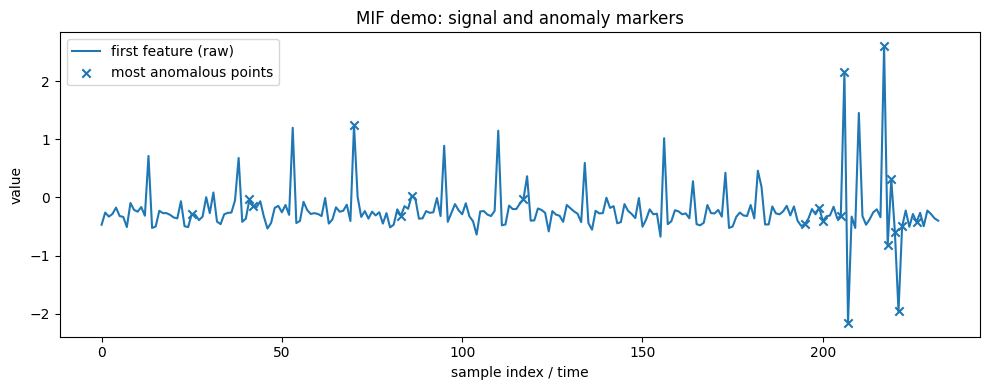

In [7]:
# Purpose of this cell:
# End-to-end demo for Modal Isolation Forest (MIF):
# 1) Load NPZ if present
# 2) Standardize features with Z-score
# 3) Build the forest and compute anomaly scores
# 4) Report top anomalous indices and visualize on a signal trace

import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

if __name__ == "__main__":
    rng = np.random.default_rng(123)

    # 1) Data: load NPZ if available; otherwise create synthetic data
    npz_path = Path("ecg_segments.npz")
    if npz_path.exists():
        data = np.load(npz_path)
        keys = list(data.files)
        preferred = ["X", "data", "segments", "ecg", "arr_0"]
        key = next((k for k in preferred if k in keys), keys[0])
        arr = data[key]
        if arr.ndim == 1:
            X_raw = arr.reshape(-1, 1).astype(float)
        elif arr.ndim == 2:
            X_raw = arr.astype(float)
        else:
            X_raw = arr.reshape(arr.shape[0], -1).astype(float)
        print(f"NPZ loaded: key={key}, shape={X_raw.shape}")
    else:
        N, h = 220, 3
        X_raw = rng.normal(size=(N, h))
        for idx in [50, 120, 180, 200]:
            X_raw[idx] += rng.normal(loc=8.0, scale=0.5, size=h)
        print(f"Synthetic data generated: shape={X_raw.shape}")

    # 2) Z-score standardization
    mu = X_raw.mean(axis=0, keepdims=True)
    sigma = X_raw.std(axis=0, keepdims=True)
    sigma = np.where(sigma == 0.0, 1.0, sigma)
    X = (X_raw - mu) / sigma
    N, h = X.shape

    # 3) Build the forest
    pbar = [0.2, 0.6, 0.2]
    t_trees = 50
    T_sub = min(256, N)
    forest = MIF(X, t=t_trees, T=T_sub, pbar=pbar, rng=rng)

    # 4) Score (use the existing score_forest)
    scores = score_forest(forest, X, T_subsample=T_sub)

    # 5) Report
    top_k = min(20, N)
    order = np.argsort(scores)[::-1]
    top_idx = order[:top_k]
    print("\nTop", top_k, "most anomalous samples:")
    for r, i in enumerate(top_idx, start=1):
        print(f"{r:2d}. i={i:4d}  score={scores[i]:.4f}")

    # Plot
    plt.figure(figsize=(10, 4))
    plt.plot(X_raw[:, 0], label="first feature (raw)")
    plt.scatter(top_idx, X_raw[top_idx, 0], marker="x", label="most anomalous points")
    plt.title("MIF demo: signal and anomaly markers")
    plt.xlabel("sample index / time")
    plt.ylabel("value")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [9]:
# Purpose of this cell:
# Unified, dataset-based benchmarking for anomaly detectors.
# Compares MIF (your implementation), scikit-learn IF, isotree EIF, LOF, and One-Class SVM on (X, y),
# computes common metrics (ROC AUC, PR AUC, F1 at a fixed percentile and best F1), and optionally plots ROC/PR curves.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- helpers ---
def minmax01(a: np.ndarray) -> np.ndarray:
    """Scale an array to [0, 1] using min-max normalization (robust to constant arrays)."""
    a = np.asarray(a, float)
    lo, hi = float(np.min(a)), float(np.max(a))
    if hi <= lo:
        return np.zeros_like(a)
    return (a - lo) / (hi - lo)

def f1_at_threshold(y_true: np.ndarray, y_score: np.ndarray, thr: float) -> float:
    """Compute F1 at a fixed threshold on scores (scores are assumed higher = more anomalous)."""
    y_pred = (y_score >= thr).astype(int)
    tp = int(((y_pred==1)&(y_true==1)).sum())
    fp = int(((y_pred==1)&(y_true==0)).sum())
    fn = int(((y_pred==0)&(y_true==1)).sum())
    prec = tp / max(tp+fp, 1)
    rec  = tp / max(tp+fn, 1)
    return 0.0 if prec+rec==0 else 2*prec*rec/(prec+rec)

def best_f1(y_true: np.ndarray, y_score: np.ndarray, max_eval=1000):
    """
    Sweep unique score thresholds (downsample if too many) to find the best F1 and its threshold.
    Returns (best_f1_value, best_threshold_on_scores).
    """
    uniq = np.unique(y_score)
    if uniq.size > max_eval:
        idx = np.linspace(0, uniq.size-1, max_eval).astype(int)
        uniq = uniq[idx]
    f1s = [f1_at_threshold(y_true, y_score, thr) for thr in uniq]
    i = int(np.argmax(f1s))
    return float(f1s[i]), float(uniq[i])

def safe_auc(y_true: np.ndarray, y_score: np.ndarray) -> float:
    """ROC AUC with a safe fallback if sklearn is unavailable or errors out."""
    try:
        from sklearn.metrics import roc_auc_score
        return float(roc_auc_score(y_true, y_score))
    except Exception:
        return 0.5

def safe_auprc(y_true: np.ndarray, y_score: np.ndarray) -> float:
    """Average Precision (PR AUC) with a safe fallback if sklearn is unavailable or errors out."""
    try:
        from sklearn.metrics import average_precision_score
        return float(average_precision_score(y_true, y_score))
    except Exception:
        return float(np.mean(y_true))

# --- scorers (from libraries) ---
def scores_if_sklearn(X: np.ndarray, n_estimators=100, max_samples=256, random_state=123):
    """IsolationForest: returns higher = more anomalous."""
    from sklearn.ensemble import IsolationForest
    mdl = IsolationForest(
        n_estimators=n_estimators,
        max_samples=min(max_samples, X.shape[0]),
        contamination="auto",
        random_state=random_state,
        n_jobs=-1
    ).fit(X)
    return -mdl.score_samples(X)

def scores_eif_isotree(X: np.ndarray, n_estimators=100, max_samples=256, random_state=123):
    """Extended Isolation Forest: returns higher = more anomalous."""
    from isotree import IsolationForest as EIF
    mdl = EIF(
        ntrees=n_estimators,
        sample_size=min(max_samples, X.shape[0]),
        seed=random_state,
        ndim=0
    )
    mdl.fit(X)
    return mdl.anomaly_score(X)

def scores_lof(X: np.ndarray, n_neighbors=20):
    """Local Outlier Factor: convert negative_outlier_factor_ to higher-is-worse scores."""
    from sklearn.neighbors import LocalOutlierFactor
    lof = LocalOutlierFactor(n_neighbors=n_neighbors, contamination="auto")
    lof.fit(X)
    return -lof.negative_outlier_factor_

def scores_ocsvm(X: np.ndarray, nu=0.05, kernel="rbf", gamma="scale"):
    """One-Class SVM: use negative decision_function so higher means more anomalous."""
    from sklearn.svm import OneClassSVM
    ocs = OneClassSVM(kernel=kernel, gamma=gamma, nu=nu)
    ocs.fit(X)
    return -ocs.decision_function(X).ravel()

# --- main function ---
def evaluate_all_models(X: np.ndarray, y: np.ndarray,
                        n_estimators=100, max_samples=256,
                        rng_seed=123, threshold_percentile=95,
                        pbar=(0.25,0.5,0.25),
                        plot_curves=True) -> pd.DataFrame:
    """
    Compare MIF, IF, EIF, LOF, One-Class SVM on (X, y).

    Inputs
    ------
    X : (N, d) array of features
    y : (N,) binary labels (1 = anomaly, 0 = normal)
    n_estimators : number of trees for tree-based methods
    max_samples  : sub-sample size per tree (capped at N)
    rng_seed     : RNG seed used for reproducibility
    threshold_percentile : percentile on normalized scores for F1@p
    pbar : modality probabilities for MIF (Y, EQ, X)
    plot_curves : whether to plot ROC and PR curves

    Returns
    -------
    DataFrame sorted by PR AUC with columns:
      method | roc_auc | pr_auc | f1@p{percentile} | best_f1 | best_thr_on_norm
    """
    named_scores = {}

    # --- MIF ---
    rng = np.random.default_rng(rng_seed)
    forest_mif = MIF(X, t=n_estimators, T=min(max_samples, X.shape[0]), pbar=pbar, rng=rng)
    # NOTE: This expects a function named `score_forest_mif`. If your scorer is `score_forest`,
    # either rename it or create a thin wrapper/alias.
    scores_mif = score_forest_mif(forest_mif, X, T_subsample=min(max_samples, X.shape[0]))
    named_scores["MIF"] = scores_mif

    # --- IF ---
    try:
        named_scores["IF"] = scores_if_sklearn(X, n_estimators, max_samples, rng_seed)
    except Exception as e:
        print("IF failed:", e)

    # --- EIF ---
    try:
        named_scores["EIF"] = scores_eif_isotree(X, n_estimators, max_samples, rng_seed)
    except Exception:
        pass

    # --- LOF ---
    try:
        named_scores["LOF"] = scores_lof(X, n_neighbors=20)
    except Exception as e:
        print("LOF failed:", e)

    # --- One-Class SVM ---
    try:
        named_scores["One-Class SVM"] = scores_ocsvm(X, nu=0.05)
    except Exception as e:
        print("OCSVM failed:", e)

    # --- metrics table ---
    rows = []
    for name, s in named_scores.items():
        s = np.asarray(s, float)
        s_norm = minmax01(s)  # normalize so percentile thresholds are comparable
        thr = float(np.percentile(s_norm, threshold_percentile))
        f1_p = f1_at_threshold(y, s_norm, thr)
        f1_m, thr_m = best_f1(y, s_norm)
        roc = safe_auc(y, s_norm)
        prc = safe_auprc(y, s_norm)
        rows.append({
            "method": name,
            "roc_auc": roc,
            "pr_auc": prc,
            f"f1@p{threshold_percentile}": f1_p,
            "best_f1": f1_m,
            "best_thr_on_norm": thr_m
        })
    df = pd.DataFrame(rows).sort_values("pr_auc", ascending=False).reset_index(drop=True)

    # --- ROC / PR plots ---
    if plot_curves:
        try:
            from sklearn.metrics import roc_curve, precision_recall_curve
            # ROC
            plt.figure(figsize=(6,4))
            for name, sc in named_scores.items():
                fpr, tpr, _ = roc_curve(y, minmax01(sc))
                plt.plot(fpr, tpr, label=name)
            plt.plot([0,1],[0,1], linestyle="--")
            plt.title("ROC curves"); plt.xlabel("FPR"); plt.ylabel("TPR"); plt.legend(); plt.tight_layout(); plt.show()

            # PR
            plt.figure(figsize=(6,4))
            for name, sc in named_scores.items():
                prec, rec, _ = precision_recall_curve(y, minmax01(sc))
                plt.plot(rec, prec, label=name)
            plt.title("Precision–Recall curves"); plt.xlabel("Recall"); plt.ylabel("Precision"); plt.legend(); plt.tight_layout(); plt.show()
        except Exception:
            pass

    return df

Feature matrix: X.shape=(22577, 34)  | Labels: y.shape=(22577,), positives=4


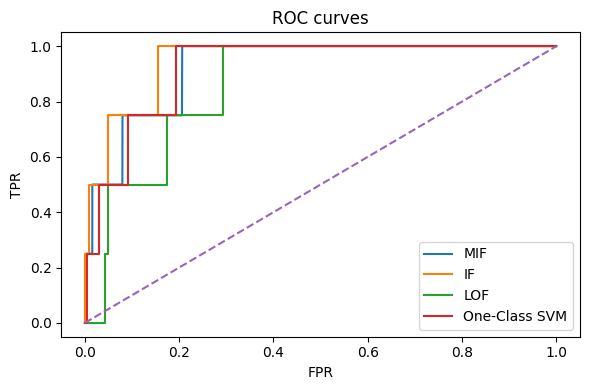

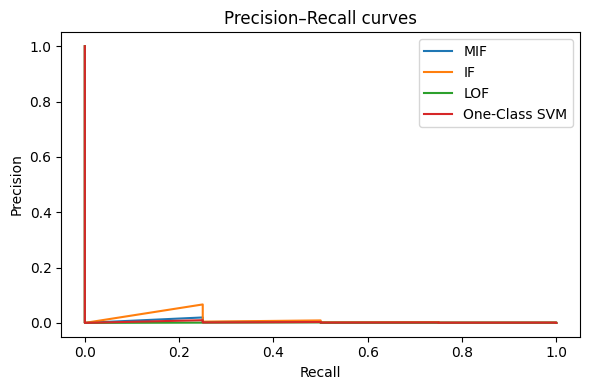

       method  roc_auc   pr_auc   f1@p95  best_f1  best_thr_on_norm
           IF 0.946308 0.019864 0.005296 0.071429          0.930077
          MIF 0.924052 0.006929 0.003524 0.036364          0.897908
One-Class SVM 0.920602 0.003782 0.003530 0.016949          0.912737
          LOF 0.860065 0.001056 0.003530 0.003594          0.016285


In [15]:
# Purpose of this cell:
# 1) flexibly parse NAB labels (intervals, single timestamps, index lists,
#  and timestamp→label maps)
# 2) build time-series features from a single VALUE_COL
# 3) optionally dilate labels 
# 4) standardize features
# 5) run evaluate_all_models
#
# Requirements:
# - Functions/classes already defined in previous cells: MIF, evaluate_all_models, score_forest (or score_forest_mif).
# - CSV has a TIME_COL and a numeric VALUE_COL.

import os, json
import numpy as np
import pandas as pd

# ---------------- Parameters (easy to tweak) ----------------
FOLDER    = r"C:\Users\ezelv\Desktop\Anomaly Ex"
CSV_NAME  = "machine_temperature_system_failure.csv"
JSONF     = "known_labels_v1.0.json"   
VALUE_COL = "value"
TIME_COL  = "timestamp"

# Feature windows (in steps)
LAGS        = (1, 2, 3)
DIFFS       = (1, 2)
ROLLS       = (5, 10, 20, 60)          # rolling mean/std/median windows
EWM_SPANS   = (10, 50)                 # exponentially weighted mean/std
DILATE_K    = 0                        # widen label window (0=off, 2 → ±2 steps)

# Benchmark hyperparameters
N_ESTIMATORS = 200
MAX_SAMPLES  = 256
RNG_SEED     = 123
PBAR         = (0.15, 0.70, 0.15)      # MIF modality probabilities (Y, EQ, X)
THR_PCT      = 95
PLOT_CURVES  = True

# ---------------- Helpers ----------------
def robust_z(x, med, mad, eps=1e-9):
    # Robust z-score: (x - median) / (MAD * 1.4826). 1.4826 scales MAD to std under normality.
    return (x - med) / (np.maximum(mad, eps) * 1.4826)

def build_features(df, value_col=VALUE_COL, time_col=TIME_COL):
    """
    Generate time-series features from a single numeric column.
    Returns a DataFrame aligned with the original index (NaN-leading rows are dropped).
    """
    if value_col not in df.columns:
        raise ValueError(f"Column '{value_col}' not found.")
    s = df[value_col].astype(float).copy()

    feat = pd.DataFrame(index=df.index)
    feat["orig"] = s

    # Lags and first/second differences (as configured)
    for k in LAGS:
        feat[f"lag_{k}"] = s.shift(k)
    for k in DIFFS:
        feat[f"diff_{k}"] = s.diff(k)

    # Rolling statistics + standard and robust z-scores
    for w in ROLLS:
        r = s.rolling(w, min_periods=w)
        m = r.mean()
        sd = r.std(ddof=0)
        med = r.median()
        mad = (s - med).abs().rolling(w, min_periods=w).median()

        feat[f"roll_mean_{w}"] = m
        feat[f"roll_std_{w}"]  = sd
        feat[f"roll_med_{w}"]  = med
        feat[f"roll_z_{w}"]    = (s - m) / (sd.replace(0.0, np.nan))
        feat[f"roll_rz_{w}"]   = robust_z(s, med, mad)

        # Simple range (max - min) over the window
        feat[f"roll_range_{w}"] = r.max() - r.min()

    # EWM (trend capture)
    for span in EWM_SPANS:
        e = s.ewm(span=span, adjust=False)
        feat[f"ewm_mean_{span}"] = e.mean()
        # EWM std via second-moment method
        m1 = e.mean()
        m2 = (s**2).ewm(span=span, adjust=False).mean()
        feat[f"ewm_std_{span}"] = np.sqrt(np.maximum(m2 - m1**2, 0.0))

    # Drop initial rows with NaNs (created by shifts/rollings)
    feat = feat.dropna(axis=0).astype(float)
    return feat

def dilate_labels(y, k):
    """
    Widen positive labels by ±k steps (event windowing).
    If k=0, return the original y unchanged.
    """
    if k <= 0:
        return y
    kernel = np.ones(2*k + 1, dtype=int)
    y_pad = np.convolve(y.astype(int), kernel, mode="same")
    return (y_pad > 0).astype(int)

# ---------------- Data load ----------------
csv_path = os.path.join(FOLDER, CSV_NAME)
df = pd.read_csv(csv_path)
if TIME_COL not in df.columns:
    raise ValueError(f"Expected a '{TIME_COL}' column in the CSV.")
df[TIME_COL] = pd.to_datetime(df[TIME_COL], errors="coerce", utc=False)

# ---------------- Flexible label build (use existing y if already present) ----------------
try:
    y  # keep externally-provided labels if they exist
except NameError:
    json_path = os.path.join(FOLDER, JSONF)
    with open(json_path, "r") as f:
        labels_all = json.load(f)

    # Find candidate keys like '.../machine_temperature_system_failure.csv'
    cands = [k for k in labels_all.keys() if k.endswith("/" + CSV_NAME) or k == CSV_NAME]
    cands = sorted(cands, key=lambda k: (not k.startswith("realKnownCause/"), k))
    if not cands:
        raise ValueError(f"No key for '{CSV_NAME}' found in JSON.")
    entry = labels_all[cands[0]]

    # Walk arbitrary JSON and extract: intervals, single timestamps, indices, and ts->label maps.
    def _to_ts(x):
        try:
            return pd.to_datetime(x, errors='coerce', utc=False)
        except Exception:
            return pd.NaT

    intervals, point_ts, index_list, stamp_map = [], [], [], {}

    def walk(obj):
        # Dict: check start/end variants, timestamp->label maps, or recurse
        if isinstance(obj, dict):
            keys = set(obj.keys())
            start_keys = {'start', 'startTime', 'start_ts', 'begin'}
            end_keys   = {'end', 'endTime', 'end_ts', 'finish'}
            if (keys & start_keys) and (keys & end_keys):
                s = _to_ts(next(obj[k] for k in (start_keys & keys)))
                e = _to_ts(next(obj[k] for k in (end_keys & keys)))
                if not pd.isna(s) and not pd.isna(e):
                    intervals.append((s, e))
                    return
            vals = list(obj.values())
            if vals and all(isinstance(v, (int, bool)) for v in vals[: min(10, len(vals))]):
                converted = {_to_ts(k): int(v) for k, v in obj.items()}
                if any(not pd.isna(k) for k in converted.keys()):
                    stamp_map.update({k: v for k, v in converted.items() if not pd.isna(k)})
                    return
            for v in obj.values():
                walk(v)
            return

        # List: flat indices, flat timestamps, or nested mixtures
        if isinstance(obj, list):
            if not obj:
                return
            if all(isinstance(x, (int, np.integer)) for x in obj[: min(10, len(obj))]):
                index_list.extend(int(x) for x in obj)
                return
            if all(isinstance(x, str) for x in obj[: min(10, len(obj))]):
                ts_list = pd.to_datetime(obj, errors='coerce', utc=False)
                point_ts.extend([ts for ts in ts_list if not pd.isna(ts)])
                return
            for v in obj:
                if isinstance(v, (list, dict)):
                    walk(v)
            return

        # Ignore other types
        return

    walk(entry)

    # Build y aligned to df length
    y = np.zeros(len(df), dtype=int)
    ts = df[TIME_COL]
    for s, e in intervals:
        y[((ts >= s) & (ts <= e)).to_numpy()] = 1
    if point_ts:
        y[ts.isin(point_ts).to_numpy()] = 1
    if index_list:
        idx = np.array(index_list, dtype=int)
        idx = idx[(idx >= 0) & (idx < len(df))]
        y[idx] = 1
    if stamp_map:
        pos_ts = [k for k, v in stamp_map.items() if int(v) == 1]
        if pos_ts:
            y[ts.isin(pos_ts).to_numpy()] = 1

# Optional label dilation
if DILATE_K > 0:
    y = dilate_labels(y, DILATE_K)

# ---------------- Feature generation and alignment ----------------
feat = build_features(df, value_col=VALUE_COL, time_col=TIME_COL)
idx_keep = feat.index.values
X_raw = feat.values
y_cut = np.asarray(y, int)[idx_keep]

# Standardization (prefer sklearn; fall back to manual z-score)
try:
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    X = scaler.fit_transform(X_raw)
except Exception:
    mu = X_raw.mean(axis=0, keepdims=True)
    sd = X_raw.std(axis=0, keepdims=True)
    sd = np.where(sd == 0.0, 1.0, sd)
    X = (X_raw - mu) / sd

print(f"Feature matrix: X.shape={X.shape}  | Labels: y.shape={y_cut.shape}, positives={int(y_cut.sum())}")

# ---------------- MIF scorer alias (compatibility) ----------------
try:
    score_forest_mif  # if evaluate_all_models expects this name
except NameError:
    score_forest_mif = score_forest  # alias to your earlier scorer name

# ---------------- Benchmark run ----------------
try:
    evaluate_all_models
except NameError:
    raise ValueError("Define evaluate_all_models in a previous cell before running this one.")

df_results = evaluate_all_models(
    X, y_cut,
    n_estimators=N_ESTIMATORS,
    max_samples=min(MAX_SAMPLES, X.shape[0]),
    rng_seed=RNG_SEED,
    threshold_percentile=THR_PCT,
    pbar=PBAR,
    plot_curves=PLOT_CURVES
)
print(df_results.to_string(index=False))
